# Identify

In [1]:
from astropy.coordinates import SkyCoord
from sunpy.coordinates import RotatedSunFrame
from sunpy.coordinates import frames

import numpy as np

import matplotlib.pyplot as plt

Maps :

In [2]:
from module import toSunpyMap

map_new = toSunpyMap('data/L2/imoa_03933_l2_20240323_13052647_emi1.fts.bz2')

# get previous image
map_old = toSunpyMap('data/L2/imoa_03933_l2_20240319_15102678_emi1.fts.bz2')

Labels :

In [3]:
from module import save_current_index

save_current_index(0)

In [4]:
from module import get_new_id, groupSunspots

table_old = groupSunspots(map_old)

Assigning NOAAs to old map table :

In [5]:
from module import getSRSTable

srs_table = getSRSTable(map_old.date)

srs_table[srs_table['ID']=='I']

ID,Number,Carrington Longitude,Area,Z,Longitudinal Extent,Number of Sunspots,Mag Type,Latitude,Longitude
,,deg,uSH,,deg,,,deg,deg
str2,int32,float64,float64,str3,float64,int32,str10,float64,float64
I,13607,314.0,50.0,Dao,5.0,7,Beta,-17.0,34.0
I,13608,304.0,10.0,Bxo,5.0,7,Beta,10.0,24.0
I,13611,271.0,10.0,Hrx,1.0,1,Alpha,28.0,-9.0
I,13613,324.0,110.0,Dai,7.0,8,Beta,-22.0,44.0
I,13614,224.0,170.0,Dai,4.0,9,Beta,16.0,-56.0
I,13615,218.0,180.0,Eao,11.0,13,Beta-Gamma,-12.0,-62.0
I,13616,311.0,50.0,Dai,5.0,12,Beta,2.0,31.0


In [6]:
date_obs = srs_table.meta['issued'].replace(hour=0, minute=0)

print('id noaa   distance\n------------------------------')
for region in srs_table[srs_table['ID']=='I']:
    point_noaa = SkyCoord(region['Longitude'],
                 region['Latitude'], 
                 obstime=date_obs, 
                 observer='earth', 
                 frame=frames.HeliographicStonyhurst,
                 )

    diffrot_point = SkyCoord(RotatedSunFrame(base=point_noaa, rotated_time=map_old.date))
    transformed_diffrot_point = diffrot_point.transform_to(map_old.coordinate_frame)
    
    label_closest_old = 0
    min_dist = np.inf
    for idx, centroid_old in enumerate(table_old):
        point_old = map_old.pixel_to_world(centroid_old['x'], centroid_old['y'])
        dist = transformed_diffrot_point.separation(point_old).deg
        
        if min_dist > dist:
            min_dist = dist
            min_idx  = idx
    
    if min_dist<0.02:
        table_old[min_idx]['noaa'] = region['Number']
        print(table_old[min_idx]['label'], ' '+str(region['Number']), ' '+str(min_dist))

id noaa   distance
------------------------------
2  13607  0.010209113739878166
1  13613  0.00674042900969869
5  13614  0.006483060180848104
3  13615  0.011609195266237795
4  13616  0.011834825790595024


In [7]:
table_old

label,id,noaa,longitude,latitude,x,y
,,,deg,deg,pix,pix
uint16,int32,int32,float64,float64,float64,float64
1,--,13613,53.65474670203527,-23.314031831425165,1698.0,727.0
2,--,13607,41.20842780210579,-19.00111731052341,1592.0,809.0
3,--,13615,-58.12987179931832,-11.540141373827801,266.0,901.0
4,--,13616,42.72138029310863,2.4594261011521152,1642.0,1145.0
5,--,13614,-50.02757235241654,16.925268235266657,356.0,1356.0


In [8]:
for line in table_old:
    line['id'] = get_new_id()

table_old

label,id,noaa,longitude,latitude,x,y
,,,deg,deg,pix,pix
uint16,int32,int32,float64,float64,float64,float64
1,1,13613,53.65474670203527,-23.314031831425165,1698.0,727.0
2,2,13607,41.20842780210579,-19.00111731052341,1592.0,809.0
3,3,13615,-58.12987179931832,-11.540141373827801,266.0,901.0
4,4,13616,42.72138029310863,2.4594261011521152,1642.0,1145.0
5,5,13614,-50.02757235241654,16.925268235266657,356.0,1356.0


Plotting NOAAs :

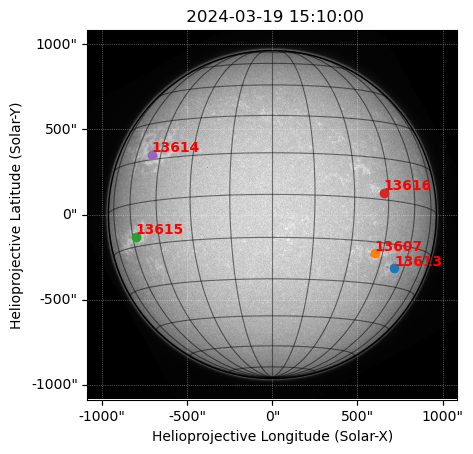

In [9]:
fig = plt.figure()
ax = fig.add_subplot(projection=map_old)
map_old.plot(axes=ax)
map_old.draw_limb(axes=ax, color="k")
map_old.draw_grid(axes=ax, color="k")

for region in table_old:
    ax.plot_coord(SkyCoord(region['longitude'],
                region['latitude'], 
                obstime=map_old.date, 
                observer='earth', 
                frame=frames.HeliographicStonyhurst,
                ).transform_to(map_old.coordinate_frame), 'o')
    ax.annotate( region['noaa'],
                (region['longitude'].value, region['latitude'].value),
                xycoords=ax.get_transform('heliographic_stonyhurst'),
                color='red',
                fontweight='bold',
                horizontalalignment='left', verticalalignment='bottom')

plt.show()

New Map :

In [10]:
table_new = groupSunspots(map_new)

table_new

label,id,noaa,longitude,latitude,x,y
,,,deg,deg,pix,pix
uint16,int32,int32,float64,float64,float64,float64
1,--,--,-4.88660115186741,-12.293311731656633,947.0,937.0
2,--,--,-36.75322491636314,-13.41099073683338,486.0,898.0
3,--,--,33.71037129690126,16.4071671618727,1516.0,1372.0
4,--,--,1.6130140579607994,16.191558481204446,1049.0,1387.0
5,--,--,-35.82716289623113,18.795738625148108,512.0,1405.0


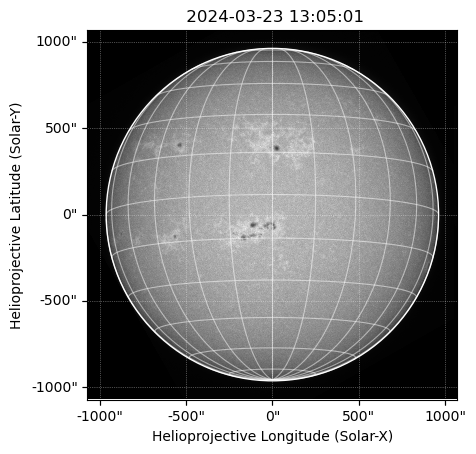

In [11]:
map_new.plot()
map_new.draw_limb()
map_new.draw_grid();

Update labels from diffrotated old map:

In [12]:
for idx, centroid_new in enumerate(table_new):
    point = map_new.pixel_to_world(centroid_new['x'], centroid_new['y'])
    diffrot_point = SkyCoord(RotatedSunFrame(base=point, rotated_time=map_old.date))
    transformed_diffrot_point = diffrot_point.transform_to(map_old.coordinate_frame)
    
    label_closest_old = 0
    min_dist = np.inf
    for centroid_old in table_old:
        point_old = map_old.pixel_to_world(centroid_old['x'], centroid_old['y'])
        dist = transformed_diffrot_point.separation(point_old).deg
        
        if min_dist > dist:
            min_dist=dist
            label_closest_old = centroid_old['id']
    
    if min_dist<0.01:
        table_new[idx]['id'] = label_closest_old
    else:
        table_new[idx]['id'] = get_new_id()

In [13]:
table_new

label,id,noaa,longitude,latitude,x,y
,,,deg,deg,pix,pix
uint16,int32,int32,float64,float64,float64,float64
1,3,--,-4.88660115186741,-12.293311731656633,947.0,937.0
2,6,--,-36.75322491636314,-13.41099073683338,486.0,898.0
3,7,--,33.71037129690126,16.4071671618727,1516.0,1372.0
4,5,--,1.6130140579607994,16.191558481204446,1049.0,1387.0
5,8,--,-35.82716289623113,18.795738625148108,512.0,1405.0


In [14]:
label_new = 3
label_old = 3

centroid_new = table_new[table_new['id']==label_new]

point = map_new.pixel_to_world(centroid_new['x'], centroid_new['y'])
diffrot_point = SkyCoord(RotatedSunFrame(base=point, rotated_time=map_old.date))
transformed_diffrot_point = diffrot_point.transform_to(map_old.coordinate_frame)

centroid_old = table_old[table_old['id']==label_old]
closest_point = map_old.pixel_to_world(centroid_old['x'], centroid_old['y'])
transformed_diffrot_point.separation(closest_point).deg

array([0.00631998])

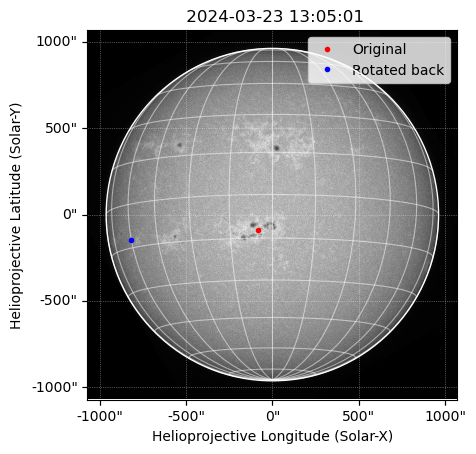

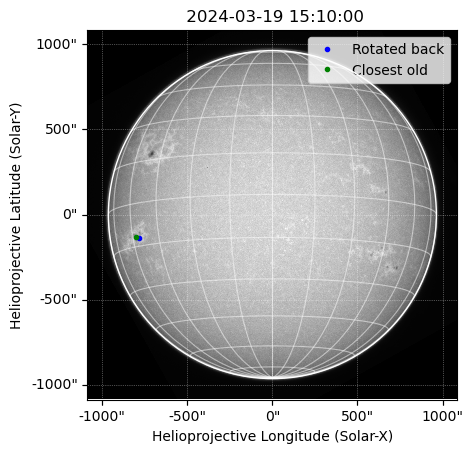

In [15]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(projection=map_new)
map_new.plot(axes=ax)
map_new.draw_limb(axes=ax)
map_new.draw_grid(axes=ax)
ax.plot_coord(point, 'r.', fillstyle='full', label='Original')
ax.plot_coord(transformed_diffrot_point, 'b.', fillstyle='full', label='Rotated back')
ax.legend(loc='upper right')

plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection=map_old)
map_old.plot(axes=ax)
map_old.draw_limb(axes=ax)
map_old.draw_grid(axes=ax)
ax.plot_coord(transformed_diffrot_point, 'b.', fillstyle='full', label='Rotated back')
ax.plot_coord(closest_point, 'g.', fillstyle='full', label='Closest old')
ax.legend(loc='upper right')

plt.show()

Assign NOAA to new table :

In [16]:
from module import assignNOAAToTable

table_new = assignNOAAToTable(table_new, map_new)

table_new

label,id,noaa,longitude,latitude,x,y
,,,deg,deg,pix,pix
uint16,int32,int32,float64,float64,float64,float64
1,3,13615,-4.88660115186741,-12.293311731656633,947.0,937.0
2,6,13617,-36.75322491636314,-13.41099073683338,486.0,898.0
3,7,--,33.71037129690126,16.4071671618727,1516.0,1372.0
4,5,13614,1.6130140579607994,16.191558481204446,1049.0,1387.0
5,8,13619,-35.82716289623113,18.795738625148108,512.0,1405.0


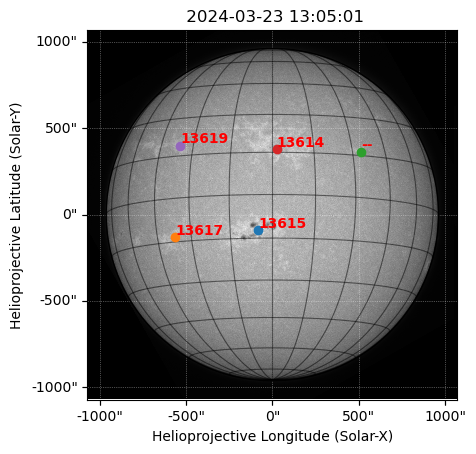

In [17]:
fig = plt.figure()
ax = fig.add_subplot(projection=map_new)
map_new.plot(axes=ax)
map_new.draw_limb(axes=ax, color="k")
map_new.draw_grid(axes=ax, color="k")

for region in table_new:
    ax.plot_coord(SkyCoord(region['longitude'],
                region['latitude'], 
                obstime=map_new.date, 
                observer='earth', 
                frame=frames.HeliographicStonyhurst,
                ).transform_to(map_new.coordinate_frame), 'o')
    ax.annotate( region['noaa'],
                (region['longitude'].value, region['latitude'].value),
                xycoords=ax.get_transform('heliographic_stonyhurst'),
                color='red',
                fontweight='bold',
                horizontalalignment='left', verticalalignment='bottom')

## Identifiers

Sunspots:
- datetime
- umbra
- penumbra
- centroids (labeled 1:end)
- identifiers (NOAA if available)

NOAA data